# Reservoir Computing for Covid dataset

## Conventional reservoir: predict patient condition using provided patient MS data

In [6]:
# Running a Cobra reservoir in predictve mode with a test set 
# Cobra is directly run with KOs instead of an AMN (no training set required)
# Results with no feature selection: 
# KO trpA Method: bayes_classifier Acc: 0.819±0.025 for 10-fold-CV and 3 iter
# results with selection:
# KO trpA Phenotype Method: bayes_classifier Acc: 0.955±0.015 for 10-fold-CV and 3 iter

import cobra
from Library.Import import *
from Library.Utilities import svm_classifier, MLP, XGB, GP 
from Library.Utilities import bayes_classifier, decision_tree_classifier
from Library.Build_Dataset import TrainingSet, create_medium_run_cobra
from sklearn.metrics import r2_score, accuracy_score, f1_score, matthews_corrcoef

DIRECTORY = './Dataset_input/Covid/'
seed = 1
np.random.seed(seed=seed)

# Create Cobra model
name = 'Covid'
cobrafile = f'{DIRECTORY}{name}_duplicated'
mediumfile  = f'{DIRECTORY}{name}'
parameter = TrainingSet(cobraname=cobrafile, 
                        mediumname=mediumfile, 
                        method='FBA')
trainingfile = f'{DIRECTORY}{name}_train'
parameter.save(trainingfile)


# Load MS data
testfile = f'{DIRECTORY}UGA/MEDIUM'
feature, X_test, y_test_true = read_XY(testfile, nY=1, scaling='X')

# Classifier set up
niter = 3
learner = MLP # To classify based on all phenotypes
scoring_function = accuracy_score
selection = 3 # To reduce the number of features when performing Leave X out, if 0 no selectin
verbose = False


KOs = ['WT  '] # + [gene.name for gene in parameter.model.genes]
i = 0            
for ko in KOs:
    i += 1
    parameter.load(trainingfile)
    # Run cobra to get growth rate for X_test
    y_pred, X = create_medium_run_cobra(parameter.model, 
                                        parameter.objective, 
                                        parameter.medium, 
                                        X_test, method='FBA', scaler=1, 
                                        genekos=[ko], verbose=verbose) 
    
    feature = [r.id for r in parameter.model.reactions]
    X[X < 1e-3] = 0
    zero_columns = np.argwhere(np.all(X == 0, axis=0)).flatten()
    X = np.delete(X, zero_columns, axis=1)
    feature = np.delete(feature, zero_columns, axis=0)
    acc_avr, acc_dev = 0.5, 0
    xfold = 20
    if X.shape[1]: 
        # Accuracy based on phenotype (X vector)
        acc_avr, acc_dev, feature = LeaveXout(X, y_test_true.ravel(), feature, 
                                     learner=learner, scoring_function=scoring_function,  
                                     xfold=xfold, niter=niter, 
                                     selection=selection, verbose=True)
        
    # Printing
    print(f'KO {ko} Phenotype Size: {X.shape[1]:4d} Method: {learner.__name__} Score: {scoring_function.__name__} '
            f'Acc: {acc_avr:.3f}±{acc_dev:.3f} '
            f'for {xfold}-fold-CV and {niter} iter')
    if selection:
       F = np.array2string(feature).replace('[','').replace(']','')
       print(f'Selected features: {F}')
        

Size: 29 Remove: FUM_rev Score: 0.881±0.015
Size: 28 Remove: EX_quin_e_i Score: 0.877±0.000
Size: 27 Remove: EX_val__L_e_i Score: 0.885±0.006
Size: 26 Remove: EX_his__L_e_i Score: 0.893±0.006
Size: 25 Remove: EX_his__L_e_o Score: 0.893±0.006
Size: 24 Remove: EX_phe__L_e_o Score: 0.893±0.006
Size: 23 Remove: THD2pp Score: 0.905±0.021
Size: 22 Remove: EX_phe__L_e_i Score: 0.918±0.012
Size: 21 Remove: FACOAE60 Score: 0.909±0.006
Size: 20 Remove: EX_indole_e_o Score: 0.918±0.012
Size: 19 Remove: NADH17pp Score: 0.914±0.010
Size: 18 Remove: PHETA1_rev Score: 0.922±0.015
Size: 17 Remove: GLUDy_for Score: 0.930±0.012
Size: 16 Remove: ATPS4rpp_i Score: 0.938±0.010
Size: 15 Remove: MDH_rev Score: 0.938±0.000
Size: 14 Remove: PHEt2rpp_i Score: 0.934±0.015
Size: 13 Remove: EX_for_e_o Score: 0.938±0.020
Size: 12 Remove: DALAt2pp Score: 0.938±0.000
Size: 11 Remove: ALAtex_i Score: 0.951±0.000
Size: 10 Remove: NH4tex_o Score: 0.942±0.012
Size: 9 Remove: SDPDS Score: 0.947±0.015
Size: 8 Remove: NH4tp

KO WT   Phenotype Size:  517 Method: XGB Score: accuracy_score Acc: 0.951±0.011 for 20-fold-CV and 3 iter
Selected features: 'ALAtex_i' 'THD2pp' 'NH4tex_o' 'VALTA_for' 'EX_phe__L_e_i'
 'EX_indole_e_o' 'VPAMTr_for'
KO WT   Phenotype Size:  517 Method: svm_classifier Score: accuracy_score Acc: 0.912±0.005 for 20-fold-CV and 3 iter
Selected features: 'NTD7pp' 'EX_for_e_o' 'NH4tex_o' 'SUCCtex_o' 'NH4tpp_o' 'VALTA_for'
 'VPAMTr_for' 'EX_quin_e_i' 'EX_indole_e_i'
KO WT   Phenotype Size:  517 Method: MLP Score: accuracy_score Acc: 0.939±0.015 for 20-fold-CV and 3 iter
Selected features: 'ALAt2pp' 'SDPDS' 'NTD7pp' 'EX_nh4_e_o' 'NH4tex_o' 'SUCCtex_o' 'NH4tpp_o'
 'PDH' 'VALTA_for' 'VPAMTr_for' 'EX_indole_e_i'

## Physical reservoir: predict patient condition using wt and KO strains growth curves

In [1]:
# Predict Patient condition using growth curves

import glob
from Library.Import    import *
from Library.Utilities import svm_classifier, MLP, XGB, GP 
from Library.Utilities import bayes_classifier, decision_tree_classifier
from Library.Utilities import LeaveXout, read_XY
from sklearn.metrics   import mean_squared_error, accuracy_score

DIRECTORY = './'
xfold = 20 #  
niter = 3
learner = XGB
scoring_function=accuracy_score
selection = 3

files = glob.glob(f'{DIRECTORY}Dataset_input/Covid/MG1655_His_Phe.csv')          
for filename in files:
    filename = os.path.splitext(filename)[0]
    feature, X, y = read_XY(filename)
    y = y[:,0]    
    # Train X, y for classification
    start_time = time.time()
    acc_avr, acc_dev, feature = LeaveXout(X, y.ravel(), feature, 
                                    learner=learner, 
                                    scoring_function=scoring_function, 
                                    xfold=xfold, niter=niter, 
                                    selection=selection, 
                                    verbose=True)
    delta_time = time.time() - start_time
    F = np.array2string(feature).replace('[','').replace(']','')
    print(f'{filename} Size: {X.shape} Method: {learner.__name__} '
      f'Acc: {acc_avr:.2f}±{acc_dev:.2f} '
      f'(for {xfold}-fold-CV and {niter} iter) '
      f'number of features: {len(feature)} cpu time {delta_time:.2f}\n')
    if selection > 0:
          print(f'Selected features: {F}')

Size: 99 Remove: MG1.655555556 Score: 0.658±0.013
Size: 98 Remove: MG2.322222222 Score: 0.676±0.066
Size: 97 Remove: Phe2.822222222 Score: 0.703±0.058
Size: 96 Remove: His4.988888889 Score: 0.721±0.046
Size: 95 Remove: His21.65555556 Score: 0.730±0.044
Size: 94 Remove: MG5.488888889 Score: 0.739±0.034
Size: 93 Remove: His20.98888889 Score: 0.748±0.025
Size: 92 Remove: His15.82222222 Score: 0.748±0.025
Size: 91 Remove: Phe14.65555556 Score: 0.748±0.025
Size: 90 Remove: His9.322222222 Score: 0.748±0.025
Size: 89 Remove: His5.655555556 Score: 0.757±0.022
Size: 88 Remove: Phe15.15555556 Score: 0.757±0.022
Size: 87 Remove: MG4.822222222 Score: 0.757±0.022
Size: 86 Remove: MG1.988888889 Score: 0.766±0.013
Size: 85 Remove: Phe5.155555556 Score: 0.766±0.013
Size: 84 Remove: Phe6.488888889 Score: 0.766±0.013
Size: 83 Remove: Phe3.655555556 Score: 0.766±0.013
Size: 82 Remove: Phe7.655555556 Score: 0.766±0.013
Size: 81 Remove: Phe5.988888889 Score: 0.766±0.013
Size: 80 Remove: Phe11.82222222 Scor

./Dataset_input/Covid/MG1655_His_Phe Size: (37, 305) Method: XGB Acc: 0.83±0.05 (for 20-fold-CV and 3 iter) number of features: 14 cpu time 7912.14
Selected features: 'Phe12.82222222' 'MG3.488888889' 'His12.82222222' 'His18.15555556'
 'Phe1.988888889' 'MG2.155555556' 'His6.488888889' 'MG2.988888889'
 'MG3.655555556' 'MG3.322222222' 'His5.155555556' 'Phe2.322222222'
 'MG4.322222222' 'MG2.488888889'



Select feature starting with all
- MG1655 reduce
- ./Dataset_input/Covid/MG1655_neg_pos_reduce Size: (64, 48) Method: XGB Acc: 0.87±0.04 (for 5-fold-CV and 3 iter) number of features: 10 cpu time 300.42 Selected features: '1.655555556' '2.155555556' '3.488888889' '3.988888889' '4.322222222'  '4.655555556' '4.822222222' '5.488888889' '7.988888889' 'y_true'
- ./Dataset_input/Covid/MG1655_mild_severe_reduce Size: (37, 48) Method: XGB Acc: 0.75±0.06 (for 5-fold-CV and 3 iter) number of features: 30 cpu time 382.50 Selected features: '1.988888889' '2.155555556' '2.322222222' '2.488888889' '2.822222222' '3.322222222' '3.488888889' '3.655555556' '3.988888889' '4.155555556'
 '4.322222222' '4.822222222' '4.988888889' '5.155555556' '5.322222222' '5.488888889' '5.655555556' '5.988888889' '6.155555556' '6.322222222' '6.488888889' '6.655555556' '6.822222222' '7.155555556' '7.322222222' '7.488888889' '7.655555556' '7.822222222' '7.988888889' 'y_true'
 
- MG1655
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: decision_tree_classifier Acc: 0.786±0.039 (for 5-fold-CV and 3 iter) number of features: 5 cpu time 9.46
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: XGB Acc: 0.820±0.025 (for 5-fold-CV and 3 iter) number of features: 5 cpu time 437.49
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: XGB Acc: 0.821±0.029 (for 5-fold-CV and 5 iter) number of features: 5 cpu time 724.39 Selected features: '0.655555556' '1.155555556' '2.655555556' '3.488888889' 
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: XGB Acc: 0.820±0.025 (for 5-fold-CV and 3 iter) number of features: 5 cpu time 490.00 Selected features: '0.655555556' '1.155555556' '2.655555556' '3.488888889'
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: XGB Acc: 0.820±0.025 (for 5-fold-CV and 3 iter) number of features: 5 cpu time 495.13 Selected features: '0.655555556' '1.155555556' '2.655555556' '3.488888889' 'y_true'
./Dataset_input/Covid/MG1655_mild_severe_smooth Size: (73, 48) Method: XGB Acc: 0.737±0.042 (for 5-fold-CV and 3 iter) number of features: 10 cpu time (73, 48)  Selected features: '0.155555556' '0.655555556' '1.822222222' '2.488888889' '3.488888889' '3.822222222' '4.488888889' '5.322222222' '5.655555556' 

- His
./Dataset_input/Covid/His_mild_severe Size: (37, 162) Method: XGB Acc: 0.754±0.051 (for 5-fold-CV and 3 iter) number of features: 7 cpu time 5601.59 Selected features: '4.822222222' '16.98888889' '19.98888889' '20.15555556' '21.48888889' '25.82222222'
./Dataset_input/Covid/His_mild_severe Size: (37, 162) Method: XGB Acc: 0.75±0.05 (for 5-fold-CV and 3 iter) number of features: 7 cpu time 5887.87 Selected features: '4.822222222' '16.98888889' '19.98888889' '20.15555556' '21.48888889' '25.82222222' 
./Dataset_input/Covid/His_mild_severe Size: (37, 162) Method: GP Acc: 0.528±0.073 (for 5-fold-CV and 3 iter) number of features: 24 cpu time 858.68
./Dataset_input/Covid/His_mild_severe Size: (37, 162) Method: decision_tree_classifier Acc: 0.668±0.083 (for 5-fold-CV and 3 iter) number of features: 6 cpu time 125.92 Selected features: '4.822222222' '20.15555556' '24.65555556' '24.98888889' '26.65555556'

OLD RUNS

Select features using random forest first
./Dataset_input/Covid/His_mild_severe Size: (37, 162) Method: XGB Acc: 0.690±0.047 (for 5-fold-CV and 5 iter) number of features: 13 cpu time 327.08
./Dataset_input/Covid/His_mild_severe Size: (37, 162) Method: GP Acc: 0.562±0.067 (for 5-fold-CV and 3 iter) number of features: 14 cpu time 30.23
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: GP Acc: 0.544±0.047 (for 5-fold-CV and 3 iter) number of features: 12 cpu time 73.64
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: XGB Acc: 0.734±0.037 (for 5-fold-CV and 3 iter) number of features: 8 cpu time 168.91
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: MLP Acc: 0.480±0.056 (for 5-fold-CV and 3 iter) number of features: 3 cpu time 41.85
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: bayes_classifier Acc: 0.698±0.035 (for 5-fold-CV and 3 iter) number of features: 7 cpu time 2.41
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: svm_classifier Acc: 0.411±0.040 (for 5-fold-CV and 3 iter) number of features: 29 cpu time 2.88
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: decision_tree_classifier Acc: 0.788±0.040 (for 5-fold-CV and 3 iter) number of features: 4 cpu time 3.36
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: decision_tree_classifier Acc: 0.769±0.038 (for 5-fold-CV and 3 iter) number of features: 5 cpu time 3.35
./Dataset_input/Covid/MG1655_mild_severe Size: (73, 48) Method: decision_tree_classifier Acc: 0.786±0.039 (for 5-fold-CV and 3 iter) number of features: 5 cpu time 9.46
./Dataset_input/Covid/MG1655_mild_severe Size: (176, 48) Method: XGB Acc: 0.626±0.028 (for 5-fold-CV and 3 iter) number of features: 49 cpu time 6.07
./Dataset_input/Covid/MG1655_mild_severe Size: (176, 48) Method: MLP Acc: 0.519±0.030 (for 5-fold-CV and 3 iter) number of features: 49 cpu time 0.83
./Dataset_input/Covid/MG1655_mild_severe Size: (176, 48) Method: svm_classifier Acc: 0.543±0.013 (for 5-fold-CV and 3 iter) number of features: 49 cpu time 0.13


GC_smooth_mean_dev_mild_severe_20 Size: (240, 114) Method: MLP Acc: 0.900±0.014 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 113.57
GC_smooth_mean_dev_mild_severe_20 Size: (240, 114) Method: MLP Acc: 0.900±0.012 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 58.89
GC_smooth_mean_dev_mild_severe_20 Size: (240, 114) Method: XGB Acc: 0.984±0.005 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 4.46
GC_smooth_mean_dev_mild_severe_20 Size: (240, 114) Method: GP Acc: 1.000±0.000 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 8270.01
GC_smooth_mean_dev_mild_severe_20 Size: (240, 114) Method: GP Acc: 1.000±0.000 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 6.23

Mild_vs_Severe_20 Size: (240, 114) Method: XGB Acc: 0.970±0.007 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 5.12
Mild_vs_Severe_tyr_20 Size: (40, 114) Method: XGB Acc: 0.958±0.024 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 1.88
Mild_vs_Severe_phe_20 Size: (40, 114) Method: XGB Acc: 0.964±0.017 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 2.08
Mild_vs_Severe_leu_20 Size: (40, 114) Method: XGB Acc: 0.968±0.013 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 2.00
Mild_vs_Severe_gly_20 Size: (40, 114) Method: XGB Acc: 0.970±0.014 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 1.87
Mild_vs_Severe_his_20 Size: (40, 114) Method: XGB Acc: 0.904±0.042 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 1.92
Mild_vs_Severe_met_20 Size: (40, 114) Method: XGB Acc: 0.941±0.022 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 2.29

Mild_vs_Severe_met_20 Size: (40, 114) Method: XGB Acc: 0.941±0.022 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 2.24
Mild_vs_Severe_met0.1_20 Size: (40, 114) Method: XGB Acc: 0.968±0.013 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 1.93
Mild_vs_Severe_met10_20 Size: (40, 114) Method: XGB Acc: 0.820±0.061 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 2.37
Mild_vs_Severe_met50_20 Size: (40, 114) Method: XGB Acc: 0.788±0.062 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 1.96

Mild_vs_Severe_met0.1_20 Size: (40, 114) Method: MLP Acc: 1.000±0.000 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 14.59
Mild_vs_Severe_met_20 Size: (40, 114) Method: MLP Acc: 1.000±0.000 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 14.37
Mild_vs_Severe_met2_20 Size: (40, 114) Method: MLP Acc: 0.633±0.033 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 8.67
Mild_vs_Severe_met10_20 Size: (40, 114) Method: MLP Acc: 0.585±0.050 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 9.11
Mild_vs_Severe_met50_20 Size: (40, 114) Method: MLP Acc: 0.460±0.057 (for 5-fold-CV and 3 iter) number of features: 115 cpu time 4.86

Iteration 1/5
Iteration 2/5
Iteration 3/5
Iteration 4/5
Iteration 5/5


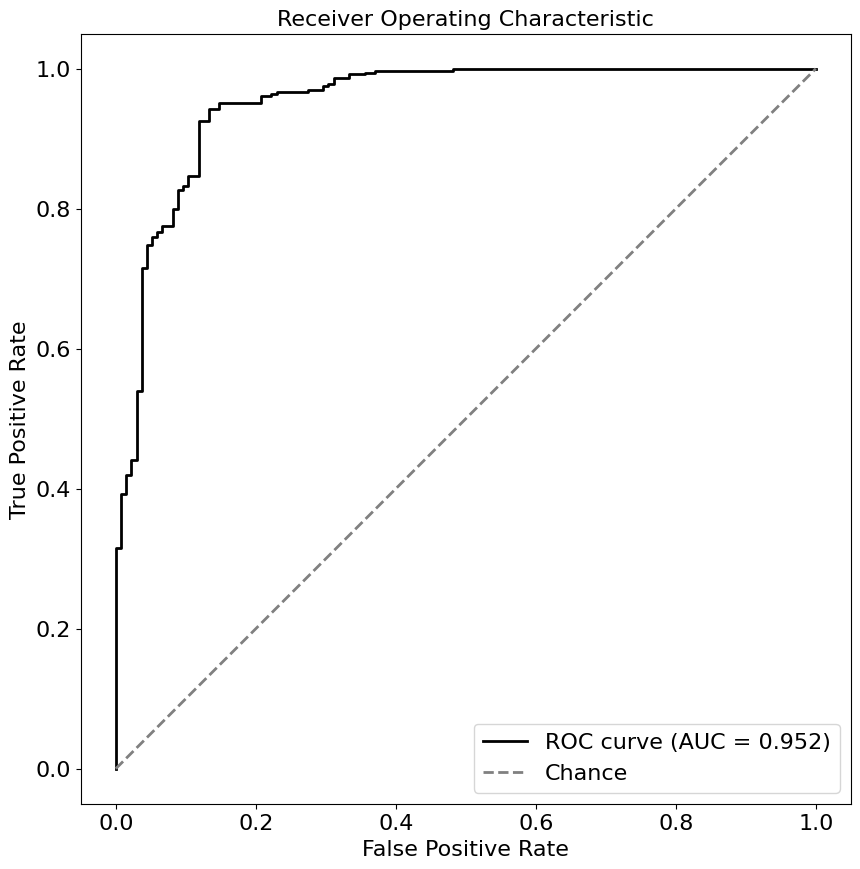

./Dataset_input/Covid/MG1655_neg_pos_12 Size: (100, 12) Method: XGB Acc: 0.908±0.007 AUC: 0.952(for 20-fold-CV and 5 iter) number of features: 13 cpu time 2.00


In [2]:
# Predict Patient condition using growth curves with selected features
# and plot ROC curve

import glob
from Library.Import    import *
from Library.Utilities import svm_classifier, MLP, XGB, GP 
from Library.Utilities import bayes_classifier, decision_tree_classifier
from Library.Utilities import LeaveXout, plot_ROC, read_XY
from sklearn.metrics   import mean_squared_error, accuracy_score

DIRECTORY = './'
niter = 5
learner = XGB
scoring_function=accuracy_score
selection = -1

filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_mild_severe_4'
filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_neg_pos_12'
feature, X, y = read_XY(filename)
xfold = 20 
y = y[:,0]    
for learner in [XGB]:
# Train X, y for classification
    start_time = time.time()
    acc_avr, acc_dev, feature = LeaveXout(X, y.ravel(), feature, 
                                    learner=learner, 
                                    scoring_function=scoring_function, 
                                    xfold=xfold, niter=niter, 
                                    selection=selection, 
                                    verbose=True)
    acc_avr = 1 - acc_avr if acc_avr < 0.5 else acc_avr
    delta_time = time.time() - start_time
    F = np.array2string(feature).replace('[','').replace(']','')
    auc = plot_ROC(X, y, learner, xfold=xfold, niter=niter, verbose=True)
    print(f'{filename} Size: {X.shape} Method: {learner.__name__} '
          f'Acc: {acc_avr:.3f}±{acc_dev:.3f} AUC: {auc:.3f}'
          f'(for {xfold}-fold-CV and {niter} iter) '
          f'number of features: {len(feature)} cpu time {delta_time:.2f}')
    if selection > 0:
        print(f'Selected features: {F}')

### Reduce MG1655

./Dataset_input/Covid/MG1655_neg_pos_reduce_9 Size: (64, 9) Method: XGB Acc: 0.870±0.038 (for 5-fold-CV and 5 iter) number of features: 10 cpu time 4.28
./Dataset_input/Covid/MG1655_neg_pos_reduce_9 Size: (64, 9) Method: XGB Acc: 0.888±0.022 (for 10-fold-CV and 5 iter) number of features: 10 cpu time 8.13
./Dataset_input/Covid/MG1655_neg_pos_reduce_9 Size: (64, 9) Method: XGB Acc: 0.921±0.008 (for 64-fold-CV and 5 iter) number of features: 10 cpu time 66.82

./Dataset_input/Covid/MG1655_mild_severe_reduce_30 Size: (37, 29) Method: XGB Acc: 0.715±0.060 (for 5-fold-CV and 5 iter) number of features: 30 cpu time 9.15
./Dataset_input/Covid/MG1655_mild_severe_reduce_30 Size: (37, 29) Method: XGB Acc: 0.747±0.045 (for 10-fold-CV and 5 iter) number of features: 30 cpu time 8.12
./Dataset_input/Covid/MG1655_mild_severe_reduce_30 Size: (37, 29) Method: XGB Acc: 0.755±0.017 (for 37-fold-CV and 5 iter) number of features: 30 cpu time 31.48 = LOO

./Dataset_input/Covid/His_mild_severe_6 Size: (37, 6) Method: XGB Acc: 0.748±0.048 (for 5-fold-CV and 5 iter) number of features: 7 cpu time 32.05
./Dataset_input/Covid/His_mild_severe_6 Size: (37, 6) Method: XGB Acc: 0.766±0.031 (for 10-fold-CV and 5 iter) number of features: 7 cpu time 66.17
./Dataset_input/Covid/His_mild_severe_6 Size: (37, 6) Method: XGB Acc: 0.772±0.013 (for 37-fold-CV and 5 iter) number of features: 7 cpu time 254.33 = LOO

### Full MG1655

./Dataset_input/Covid/MG1655_neg_pos_12 Size: (100, 12) Method: XGB Acc: 0.899±0.025 (for 5-fold-CV and 5 iter) number of features: 13 cpu time 5.67
./Dataset_input/Covid/MG1655_neg_pos_12 Size: (100, 12) Method: XGB Acc: 0.908±0.018 (for 10-fold-CV and 5 iter) number of features: 13 cpu time 70.16
./Dataset_input/Covid/MG1655_neg_pos_12 Size: (100, 12) Method: XGB Acc: 0.913±0.008 (for 100-fold-CV and 5 iter) number of features: 13 cpu time 743.71 = LOO

./Dataset_input/Covid/MG1655_mild_severe_4 Size: (73, 4) Method: XGB Acc: 0.821±0.029 (for 5-fold-CV and 5 iter) number of features: 5 cpu time 46.91
./Dataset_input/Covid/MG1655_mild_severe_4 Size: (73, 4) Method: XGB Acc: 0.845±0.020 (for 10-fold-CV and 5 iter) number of features: 5 cpu time 97.30
./Dataset_input/Covid/MG1655_mild_severe_4 Size: (73, 4) Method: XGB Acc: 0.880±0.007 (for 73-fold-CV and 5 iter) number of features: 5 cpu time 731.14 = LOO
